In [44]:
# Importing the modules for collecting and building the dataset
import time
import os
import re
# Web-scraping...
from urllib.request import Request, urlopen
from urllib.request import URLError, HTTPError
import pil
# Image processing...
from pil import Image

In [45]:
cars = [ 'Audi', 'BMW', 'Chevrolet', 'Citroen', 'Volvo']

kwrds = ['logo', 'logotype', 'logo png', 'logo gif', 'logo jpg', 'logo front',
         'logo rear', 'badge', 'logo white', 'logo black', 'logo transparent']

# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [46]:
# Loading the image file
image_path = 'nimg/'
imgs = os.listdir(image_path)
img_x = img_y = 50 # image size is constant
n_samples = np.size(imgs)
n_samples 

105

In [47]:
# Loading all images...
images = np.array([np.array(Image.open(image_path + img).convert("RGB")).flatten() for img in os.listdir(image_path)], order='F', dtype='uint8')
np.shape(images)

(105, 7500)

In [48]:
# an example image
images[1][1:]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [49]:
# Producing labels and assigning them accordingly
labels = np.array([cars.index(re.match(r"(^\D+)", imgs[i])[0]) for i in range(n_samples)])
labels.shape

(105,)

In [50]:
# Some additional data preparation needs to be done before blasting the images into the neural net
dataset, labelset = shuffle(images, labels, random_state=42) # 42, what else? ;)
train_data = [dataset, labelset]

(105, 7500) (105,)


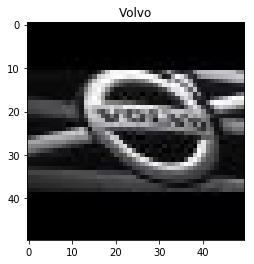

In [51]:
# Testing 
r = 100
print(train_data[0].shape, train_data[1].shape)
plt.imshow(images[r].reshape(img_x, img_y, 3))
plt.title(cars[labels[r]])
plt.show()

# Training the dataset

In [52]:
# We have to prepare the dataset to fit into the CNN
X_train, X_test, y_train, y_test = train_test_split(train_data[0], train_data[1], test_size=0.2)

# we will maintain a copy of the test set
X_test_img = X_test.copy()

X_train = X_train.reshape(X_train.shape[0], img_x, img_y, 3)
X_test = X_test.reshape(X_test.shape[0], img_x, img_y, 3)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

#some additional pre-processing.
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

#scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(cars))
Y_test = np_utils.to_categorical(y_test, num_classes=len(cars))

In [53]:
#Shape of data
X_train.shape, X_test.shape

((84, 50, 50, 3), (21, 50, 50, 3))

# Data Agumentation

In [54]:
# In order to process data augmentation, keras' ImageDataGenerator can apply some transformations to images on random
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

In [55]:
# It has to be 'fit' into the training set
datagen.fit(X_train)

# Buliding the CNN model

In [56]:
# some CNN construction!

# setting up batch size 
batch = 64

# there are 5 brands altogether
n_classes = len(cars)

# setting up the number of epochs to be trained
n_epochs = 1500

# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively
n_channels = 3

In [57]:
# Convolutional Neural Network will be composed of four Conv/MaxPool blocks, a flattening layer and two dense layers at the end
# (before the final classification layer, that is)

model = Sequential()
model.add(Conv2D(32, (3,3),
                 input_shape=(img_x,img_y,n_channels),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (3,3),
                 padding='valid',
                 bias_initializer='glorot_uniform',
                 kernel_regularizer=l2(0.00004),
                 kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))


model.add(Dense(4096, activation='relu', bias_initializer='glorot_uniform'))
model.add(Dropout(0.5))

# final activation is softmax, tuned to the number of classes/labels possible
model.add(Dense(len(cars), activation='softmax'))

# Some callbacks have to be provided to choose the best trained model

early_stopping = EarlyStopping(patience=4, monitor='val_loss')
CNN_file = 'car_CNN_13AUGM_CMCMCMCMF.h5py' 
take_best_model = ModelCheckpoint(CNN_file, save_best_only=True)

# optimizer will be a stochastic gradient descent, learning rate set at 0.005
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])

# Let's look at the summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 256)         295168    
__________

# Image data generator


First I used batch=32 and epoch=500 then I got 66.67% accuracy.
I have updated my batch_size to 64 and epoch size 800 then I got 71.23% Accuracy.
now I have updated my epoch to 1200 I got 76.19% accuracy. I have updated epoch to 1500 and I got success rate of 94%.

In [58]:
#Training
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch, shuffle=True, seed=42),\
                    steps_per_epoch=X_train.shape[0]//batch, epochs=n_epochs,\
                    validation_data=(X_test, Y_test), workers=4)

Epoch 1/1500
1/1 [==============================] - 4s 4s/step - loss: 1.7134 - categorical_accuracy: 0.2500 - val_loss: 1.6112 - val_categorical_accuracy: 0.2857
Epoch 2/1500
1/1 [==============================] - 0s 420ms/step - loss: 1.8712 - categorical_accuracy: 0.1500 - val_loss: 2.3890 - val_categorical_accuracy: 0.0952
Epoch 3/1500
1/1 [==============================] - 1s 650ms/step - loss: 2.1742 - categorical_accuracy: 0.2031 - val_loss: 1.5616 - val_categorical_accuracy: 0.3333
Epoch 4/1500
1/1 [==============================] - 0s 406ms/step - loss: 1.7711 - categorical_accuracy: 0.2000 - val_loss: 1.8387 - val_categorical_accuracy: 0.2381
Epoch 5/1500
1/1 [==============================] - 1s 665ms/step - loss: 1.6838 - categorical_accuracy: 0.2656 - val_loss: 1.7311 - val_categorical_accuracy: 0.1905
Epoch 6/1500
1/1 [==============================] - 0s 487ms/step - loss: 1.7394 - categorical_accuracy: 0.2000 - val_loss: 1.5420 - val_categorical_accuracy: 0.2381
Epoch 7

Epoch 51/1500
1/1 [==============================] - 1s 574ms/step - loss: 1.2342 - categorical_accuracy: 0.5469 - val_loss: 1.1996 - val_categorical_accuracy: 0.5238
Epoch 52/1500
1/1 [==============================] - 0s 375ms/step - loss: 0.9993 - categorical_accuracy: 0.5500 - val_loss: 1.2290 - val_categorical_accuracy: 0.5238
Epoch 53/1500
1/1 [==============================] - 1s 598ms/step - loss: 0.9417 - categorical_accuracy: 0.6406 - val_loss: 1.1927 - val_categorical_accuracy: 0.5714
Epoch 54/1500
1/1 [==============================] - 0s 367ms/step - loss: 1.0175 - categorical_accuracy: 0.5000 - val_loss: 1.1789 - val_categorical_accuracy: 0.5714
Epoch 55/1500
1/1 [==============================] - 1s 582ms/step - loss: 0.9176 - categorical_accuracy: 0.6406 - val_loss: 1.1867 - val_categorical_accuracy: 0.5714
Epoch 56/1500
1/1 [==============================] - 0s 385ms/step - loss: 1.1549 - categorical_accuracy: 0.5500 - val_loss: 1.3842 - val_categorical_accuracy: 0.428

1/1 [==============================] - 0s 367ms/step - loss: 0.4810 - categorical_accuracy: 0.9000 - val_loss: 1.4308 - val_categorical_accuracy: 0.6190
Epoch 101/1500
1/1 [==============================] - 1s 600ms/step - loss: 0.7038 - categorical_accuracy: 0.7656 - val_loss: 1.3575 - val_categorical_accuracy: 0.6667
Epoch 102/1500
1/1 [==============================] - 0s 365ms/step - loss: 0.5301 - categorical_accuracy: 0.8000 - val_loss: 1.3307 - val_categorical_accuracy: 0.6667
Epoch 103/1500
1/1 [==============================] - 1s 598ms/step - loss: 0.3883 - categorical_accuracy: 0.8750 - val_loss: 1.3567 - val_categorical_accuracy: 0.6190
Epoch 104/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.8522 - categorical_accuracy: 0.7000 - val_loss: 1.3515 - val_categorical_accuracy: 0.6190
Epoch 105/1500
1/1 [==============================] - 1s 582ms/step - loss: 0.7621 - categorical_accuracy: 0.7812 - val_loss: 1.3272 - val_categorical_accuracy: 0.6190
Epoch 1

Epoch 149/1500
1/1 [==============================] - 1s 626ms/step - loss: 0.5062 - categorical_accuracy: 0.8438 - val_loss: 1.1710 - val_categorical_accuracy: 0.7143
Epoch 150/1500
1/1 [==============================] - 0s 389ms/step - loss: 0.3373 - categorical_accuracy: 0.9000 - val_loss: 1.3010 - val_categorical_accuracy: 0.6190
Epoch 151/1500
1/1 [==============================] - 1s 606ms/step - loss: 0.3771 - categorical_accuracy: 0.8594 - val_loss: 1.2830 - val_categorical_accuracy: 0.6667
Epoch 152/1500
1/1 [==============================] - 0s 392ms/step - loss: 0.3371 - categorical_accuracy: 0.9500 - val_loss: 1.3562 - val_categorical_accuracy: 0.6667
Epoch 153/1500
1/1 [==============================] - 1s 620ms/step - loss: 0.5597 - categorical_accuracy: 0.8281 - val_loss: 1.3000 - val_categorical_accuracy: 0.6667
Epoch 154/1500
1/1 [==============================] - 0s 452ms/step - loss: 0.3386 - categorical_accuracy: 0.8500 - val_loss: 1.4920 - val_categorical_accuracy:

Epoch 198/1500
1/1 [==============================] - 0s 403ms/step - loss: 0.2761 - categorical_accuracy: 0.9000 - val_loss: 1.6524 - val_categorical_accuracy: 0.7143
Epoch 199/1500
1/1 [==============================] - 1s 577ms/step - loss: 0.3011 - categorical_accuracy: 0.8750 - val_loss: 1.6771 - val_categorical_accuracy: 0.7619
Epoch 200/1500
1/1 [==============================] - 0s 427ms/step - loss: 0.4225 - categorical_accuracy: 0.9000 - val_loss: 1.8187 - val_categorical_accuracy: 0.7143
Epoch 201/1500
1/1 [==============================] - 1s 571ms/step - loss: 0.4836 - categorical_accuracy: 0.8281 - val_loss: 1.4447 - val_categorical_accuracy: 0.7619
Epoch 202/1500
1/1 [==============================] - 0s 393ms/step - loss: 0.0562 - categorical_accuracy: 1.0000 - val_loss: 1.4196 - val_categorical_accuracy: 0.7619
Epoch 203/1500
1/1 [==============================] - 1s 571ms/step - loss: 0.3813 - categorical_accuracy: 0.9219 - val_loss: 1.2745 - val_categorical_accuracy:

Epoch 247/1500
1/1 [==============================] - 1s 624ms/step - loss: 0.2220 - categorical_accuracy: 0.9219 - val_loss: 1.5400 - val_categorical_accuracy: 0.7143
Epoch 248/1500
1/1 [==============================] - 0s 373ms/step - loss: 0.0763 - categorical_accuracy: 1.0000 - val_loss: 1.6323 - val_categorical_accuracy: 0.7619
Epoch 249/1500
1/1 [==============================] - 1s 569ms/step - loss: 0.1141 - categorical_accuracy: 0.9688 - val_loss: 1.6614 - val_categorical_accuracy: 0.7619
Epoch 250/1500
1/1 [==============================] - 0s 404ms/step - loss: 0.3126 - categorical_accuracy: 0.9000 - val_loss: 1.6174 - val_categorical_accuracy: 0.7143
Epoch 251/1500
1/1 [==============================] - 1s 616ms/step - loss: 0.0849 - categorical_accuracy: 1.0000 - val_loss: 1.6227 - val_categorical_accuracy: 0.7143
Epoch 252/1500
1/1 [==============================] - 0s 416ms/step - loss: 0.1396 - categorical_accuracy: 0.9500 - val_loss: 1.5880 - val_categorical_accuracy:

Epoch 296/1500
1/1 [==============================] - 0s 363ms/step - loss: 0.1632 - categorical_accuracy: 0.9500 - val_loss: 1.8961 - val_categorical_accuracy: 0.7619
Epoch 297/1500
1/1 [==============================] - 1s 581ms/step - loss: 0.0713 - categorical_accuracy: 1.0000 - val_loss: 1.9905 - val_categorical_accuracy: 0.7619
Epoch 298/1500
1/1 [==============================] - 0s 376ms/step - loss: 0.1023 - categorical_accuracy: 1.0000 - val_loss: 2.1980 - val_categorical_accuracy: 0.7619
Epoch 299/1500
1/1 [==============================] - 1s 576ms/step - loss: 0.1843 - categorical_accuracy: 0.9688 - val_loss: 1.9807 - val_categorical_accuracy: 0.8095
Epoch 300/1500
1/1 [==============================] - 0s 378ms/step - loss: 0.1278 - categorical_accuracy: 1.0000 - val_loss: 2.0844 - val_categorical_accuracy: 0.8095
Epoch 301/1500
1/1 [==============================] - 1s 586ms/step - loss: 0.2150 - categorical_accuracy: 0.9531 - val_loss: 2.0396 - val_categorical_accuracy:

Epoch 345/1500
1/1 [==============================] - 1s 570ms/step - loss: 0.0651 - categorical_accuracy: 1.0000 - val_loss: 1.6357 - val_categorical_accuracy: 0.8095
Epoch 346/1500
1/1 [==============================] - 0s 415ms/step - loss: 0.0531 - categorical_accuracy: 1.0000 - val_loss: 1.6744 - val_categorical_accuracy: 0.8095
Epoch 347/1500
1/1 [==============================] - 1s 588ms/step - loss: 0.0721 - categorical_accuracy: 1.0000 - val_loss: 1.6849 - val_categorical_accuracy: 0.8095
Epoch 348/1500
1/1 [==============================] - 0s 384ms/step - loss: 0.0506 - categorical_accuracy: 1.0000 - val_loss: 1.7099 - val_categorical_accuracy: 0.8095
Epoch 349/1500
1/1 [==============================] - 1s 582ms/step - loss: 0.0665 - categorical_accuracy: 0.9844 - val_loss: 1.7536 - val_categorical_accuracy: 0.8095
Epoch 350/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.0994 - categorical_accuracy: 0.9500 - val_loss: 1.8188 - val_categorical_accuracy:

Epoch 394/1500
1/1 [==============================] - 0s 376ms/step - loss: 0.0913 - categorical_accuracy: 1.0000 - val_loss: 1.9668 - val_categorical_accuracy: 0.8095
Epoch 395/1500
1/1 [==============================] - 1s 583ms/step - loss: 0.1105 - categorical_accuracy: 0.9531 - val_loss: 2.0673 - val_categorical_accuracy: 0.8095
Epoch 396/1500
1/1 [==============================] - 0s 407ms/step - loss: 0.4744 - categorical_accuracy: 0.8500 - val_loss: 2.0828 - val_categorical_accuracy: 0.7619
Epoch 397/1500
1/1 [==============================] - 1s 574ms/step - loss: 0.0868 - categorical_accuracy: 0.9688 - val_loss: 2.4103 - val_categorical_accuracy: 0.6190
Epoch 398/1500
1/1 [==============================] - 0s 361ms/step - loss: 0.1526 - categorical_accuracy: 0.9500 - val_loss: 2.8198 - val_categorical_accuracy: 0.5238
Epoch 399/1500
1/1 [==============================] - 1s 633ms/step - loss: 0.3294 - categorical_accuracy: 0.8750 - val_loss: 2.3226 - val_categorical_accuracy:

Epoch 443/1500
1/1 [==============================] - 1s 598ms/step - loss: 0.0878 - categorical_accuracy: 0.9844 - val_loss: 1.6207 - val_categorical_accuracy: 0.7619
Epoch 444/1500
1/1 [==============================] - 0s 352ms/step - loss: 0.0787 - categorical_accuracy: 1.0000 - val_loss: 1.7043 - val_categorical_accuracy: 0.7619
Epoch 445/1500
1/1 [==============================] - 1s 615ms/step - loss: 0.1587 - categorical_accuracy: 0.9375 - val_loss: 1.6368 - val_categorical_accuracy: 0.7619
Epoch 446/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.1471 - categorical_accuracy: 0.9500 - val_loss: 1.6104 - val_categorical_accuracy: 0.7619
Epoch 447/1500
1/1 [==============================] - 1s 571ms/step - loss: 0.1506 - categorical_accuracy: 0.9531 - val_loss: 1.5750 - val_categorical_accuracy: 0.7143
Epoch 448/1500
1/1 [==============================] - 0s 421ms/step - loss: 0.0778 - categorical_accuracy: 1.0000 - val_loss: 1.3088 - val_categorical_accuracy:

Epoch 492/1500
1/1 [==============================] - 0s 369ms/step - loss: 0.0571 - categorical_accuracy: 1.0000 - val_loss: 2.0874 - val_categorical_accuracy: 0.6667
Epoch 493/1500
1/1 [==============================] - 1s 585ms/step - loss: 0.1910 - categorical_accuracy: 0.9531 - val_loss: 1.9991 - val_categorical_accuracy: 0.6667
Epoch 494/1500
1/1 [==============================] - 0s 385ms/step - loss: 0.2979 - categorical_accuracy: 0.9000 - val_loss: 1.3183 - val_categorical_accuracy: 0.8095
Epoch 495/1500
1/1 [==============================] - 1s 598ms/step - loss: 0.0806 - categorical_accuracy: 1.0000 - val_loss: 1.2453 - val_categorical_accuracy: 0.8095
Epoch 496/1500
1/1 [==============================] - 0s 454ms/step - loss: 0.0455 - categorical_accuracy: 1.0000 - val_loss: 1.2075 - val_categorical_accuracy: 0.8095
Epoch 497/1500
1/1 [==============================] - 1s 630ms/step - loss: 0.1186 - categorical_accuracy: 0.9688 - val_loss: 1.2107 - val_categorical_accuracy:

Epoch 541/1500
1/1 [==============================] - 1s 608ms/step - loss: 0.0878 - categorical_accuracy: 0.9844 - val_loss: 1.9248 - val_categorical_accuracy: 0.7143
Epoch 542/1500
1/1 [==============================] - 0s 366ms/step - loss: 0.0969 - categorical_accuracy: 0.9500 - val_loss: 2.1645 - val_categorical_accuracy: 0.7143
Epoch 543/1500
1/1 [==============================] - 1s 584ms/step - loss: 0.0572 - categorical_accuracy: 0.9844 - val_loss: 2.4630 - val_categorical_accuracy: 0.7143
Epoch 544/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.1692 - categorical_accuracy: 0.9500 - val_loss: 2.4771 - val_categorical_accuracy: 0.6667
Epoch 545/1500
1/1 [==============================] - 1s 582ms/step - loss: 0.1177 - categorical_accuracy: 0.9844 - val_loss: 2.4603 - val_categorical_accuracy: 0.7143
Epoch 546/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.0628 - categorical_accuracy: 1.0000 - val_loss: 2.4660 - val_categorical_accuracy:

Epoch 590/1500
1/1 [==============================] - 0s 418ms/step - loss: 0.3524 - categorical_accuracy: 0.9000 - val_loss: 1.5846 - val_categorical_accuracy: 0.7619
Epoch 591/1500
1/1 [==============================] - 1s 630ms/step - loss: 0.1768 - categorical_accuracy: 0.9531 - val_loss: 1.6895 - val_categorical_accuracy: 0.7143
Epoch 592/1500
1/1 [==============================] - 0s 389ms/step - loss: 0.1034 - categorical_accuracy: 1.0000 - val_loss: 1.7306 - val_categorical_accuracy: 0.7619
Epoch 593/1500
1/1 [==============================] - 1s 637ms/step - loss: 0.1278 - categorical_accuracy: 0.9688 - val_loss: 1.8427 - val_categorical_accuracy: 0.6667
Epoch 594/1500
1/1 [==============================] - 0s 404ms/step - loss: 0.6314 - categorical_accuracy: 0.9000 - val_loss: 2.0591 - val_categorical_accuracy: 0.7143
Epoch 595/1500
1/1 [==============================] - 1s 617ms/step - loss: 0.2356 - categorical_accuracy: 0.9531 - val_loss: 2.2418 - val_categorical_accuracy:

Epoch 639/1500
1/1 [==============================] - 1s 614ms/step - loss: 0.2463 - categorical_accuracy: 0.9531 - val_loss: 1.4502 - val_categorical_accuracy: 0.7143
Epoch 640/1500
1/1 [==============================] - 0s 382ms/step - loss: 0.4631 - categorical_accuracy: 0.9500 - val_loss: 1.6678 - val_categorical_accuracy: 0.7143
Epoch 641/1500
1/1 [==============================] - 1s 584ms/step - loss: 0.1787 - categorical_accuracy: 0.9531 - val_loss: 1.8033 - val_categorical_accuracy: 0.7619
Epoch 642/1500
1/1 [==============================] - 0s 382ms/step - loss: 0.2957 - categorical_accuracy: 0.8500 - val_loss: 2.1991 - val_categorical_accuracy: 0.7143
Epoch 643/1500
1/1 [==============================] - 1s 601ms/step - loss: 0.1798 - categorical_accuracy: 0.9531 - val_loss: 2.2981 - val_categorical_accuracy: 0.6667
Epoch 644/1500
1/1 [==============================] - 0s 402ms/step - loss: 0.3297 - categorical_accuracy: 0.8500 - val_loss: 2.1405 - val_categorical_accuracy:

Epoch 688/1500
1/1 [==============================] - 0s 377ms/step - loss: 0.0555 - categorical_accuracy: 1.0000 - val_loss: 1.7407 - val_categorical_accuracy: 0.7143
Epoch 689/1500
1/1 [==============================] - 1s 600ms/step - loss: 0.1068 - categorical_accuracy: 0.9688 - val_loss: 1.7255 - val_categorical_accuracy: 0.7143
Epoch 690/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.0650 - categorical_accuracy: 1.0000 - val_loss: 1.7516 - val_categorical_accuracy: 0.7143
Epoch 691/1500
1/1 [==============================] - 1s 587ms/step - loss: 0.2421 - categorical_accuracy: 0.9375 - val_loss: 1.7361 - val_categorical_accuracy: 0.7143
Epoch 692/1500
1/1 [==============================] - 0s 386ms/step - loss: 0.1052 - categorical_accuracy: 0.9500 - val_loss: 1.7182 - val_categorical_accuracy: 0.6667
Epoch 693/1500
1/1 [==============================] - 1s 596ms/step - loss: 0.2050 - categorical_accuracy: 0.9531 - val_loss: 1.7206 - val_categorical_accuracy:

Epoch 737/1500
1/1 [==============================] - 1s 600ms/step - loss: 0.0517 - categorical_accuracy: 1.0000 - val_loss: 2.2464 - val_categorical_accuracy: 0.6190
Epoch 738/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.0474 - categorical_accuracy: 1.0000 - val_loss: 2.3050 - val_categorical_accuracy: 0.6190
Epoch 739/1500
1/1 [==============================] - 1s 565ms/step - loss: 0.0818 - categorical_accuracy: 0.9844 - val_loss: 2.1734 - val_categorical_accuracy: 0.6667
Epoch 740/1500
1/1 [==============================] - 0s 366ms/step - loss: 0.0413 - categorical_accuracy: 1.0000 - val_loss: 2.1723 - val_categorical_accuracy: 0.6667
Epoch 741/1500
1/1 [==============================] - 1s 551ms/step - loss: 0.0445 - categorical_accuracy: 1.0000 - val_loss: 2.1761 - val_categorical_accuracy: 0.6667
Epoch 742/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.1805 - categorical_accuracy: 0.9500 - val_loss: 1.8733 - val_categorical_accuracy:

Epoch 786/1500
1/1 [==============================] - 0s 368ms/step - loss: 0.0458 - categorical_accuracy: 1.0000 - val_loss: 1.9518 - val_categorical_accuracy: 0.8571
Epoch 787/1500
1/1 [==============================] - 1s 603ms/step - loss: 0.0467 - categorical_accuracy: 1.0000 - val_loss: 1.9365 - val_categorical_accuracy: 0.8571
Epoch 788/1500
1/1 [==============================] - 0s 382ms/step - loss: 0.0427 - categorical_accuracy: 1.0000 - val_loss: 1.9299 - val_categorical_accuracy: 0.8571
Epoch 789/1500
1/1 [==============================] - 1s 615ms/step - loss: 0.1552 - categorical_accuracy: 0.9531 - val_loss: 1.8728 - val_categorical_accuracy: 0.8571
Epoch 790/1500
1/1 [==============================] - 0s 383ms/step - loss: 0.0424 - categorical_accuracy: 1.0000 - val_loss: 1.8557 - val_categorical_accuracy: 0.8095
Epoch 791/1500
1/1 [==============================] - 1s 611ms/step - loss: 0.0785 - categorical_accuracy: 0.9844 - val_loss: 1.8105 - val_categorical_accuracy:

Epoch 835/1500
1/1 [==============================] - 1s 581ms/step - loss: 0.0764 - categorical_accuracy: 0.9844 - val_loss: 2.1486 - val_categorical_accuracy: 0.7619
Epoch 836/1500
1/1 [==============================] - 0s 392ms/step - loss: 0.0426 - categorical_accuracy: 1.0000 - val_loss: 2.2418 - val_categorical_accuracy: 0.7619
Epoch 837/1500
1/1 [==============================] - 1s 648ms/step - loss: 0.0474 - categorical_accuracy: 1.0000 - val_loss: 2.3491 - val_categorical_accuracy: 0.7619
Epoch 838/1500
1/1 [==============================] - 0s 398ms/step - loss: 0.2253 - categorical_accuracy: 0.9000 - val_loss: 1.5554 - val_categorical_accuracy: 0.7619
Epoch 839/1500
1/1 [==============================] - 1s 599ms/step - loss: 0.0438 - categorical_accuracy: 1.0000 - val_loss: 1.3193 - val_categorical_accuracy: 0.8095
Epoch 840/1500
1/1 [==============================] - 0s 388ms/step - loss: 0.0930 - categorical_accuracy: 0.9500 - val_loss: 1.2432 - val_categorical_accuracy:

Epoch 884/1500
1/1 [==============================] - 1s 512ms/step - loss: 0.0695 - categorical_accuracy: 1.0000 - val_loss: 1.9159 - val_categorical_accuracy: 0.6667
Epoch 885/1500
1/1 [==============================] - 1s 628ms/step - loss: 0.0709 - categorical_accuracy: 1.0000 - val_loss: 1.9719 - val_categorical_accuracy: 0.7619
Epoch 886/1500
1/1 [==============================] - 0s 378ms/step - loss: 0.0607 - categorical_accuracy: 1.0000 - val_loss: 2.0179 - val_categorical_accuracy: 0.7143
Epoch 887/1500
1/1 [==============================] - 1s 606ms/step - loss: 0.0557 - categorical_accuracy: 1.0000 - val_loss: 2.0623 - val_categorical_accuracy: 0.7143
Epoch 888/1500
1/1 [==============================] - 0s 378ms/step - loss: 0.2122 - categorical_accuracy: 0.9500 - val_loss: 2.1122 - val_categorical_accuracy: 0.7143
Epoch 889/1500
1/1 [==============================] - 1s 609ms/step - loss: 0.1020 - categorical_accuracy: 0.9844 - val_loss: 2.1786 - val_categorical_accuracy:

Epoch 933/1500
1/1 [==============================] - 1s 618ms/step - loss: 0.1065 - categorical_accuracy: 0.9844 - val_loss: 1.7951 - val_categorical_accuracy: 0.8095
Epoch 934/1500
1/1 [==============================] - 0s 418ms/step - loss: 0.0501 - categorical_accuracy: 1.0000 - val_loss: 1.7567 - val_categorical_accuracy: 0.8095
Epoch 935/1500
1/1 [==============================] - 1s 614ms/step - loss: 0.0466 - categorical_accuracy: 1.0000 - val_loss: 1.7338 - val_categorical_accuracy: 0.8571
Epoch 936/1500
1/1 [==============================] - 0s 401ms/step - loss: 0.1963 - categorical_accuracy: 0.9000 - val_loss: 1.7863 - val_categorical_accuracy: 0.8571
Epoch 937/1500
1/1 [==============================] - 1s 662ms/step - loss: 0.0655 - categorical_accuracy: 1.0000 - val_loss: 1.8934 - val_categorical_accuracy: 0.8095
Epoch 938/1500
1/1 [==============================] - 0s 399ms/step - loss: 0.0577 - categorical_accuracy: 1.0000 - val_loss: 2.1316 - val_categorical_accuracy:

Epoch 982/1500
1/1 [==============================] - 0s 363ms/step - loss: 0.0456 - categorical_accuracy: 1.0000 - val_loss: 1.9451 - val_categorical_accuracy: 0.7619
Epoch 983/1500
1/1 [==============================] - 1s 599ms/step - loss: 0.0842 - categorical_accuracy: 0.9844 - val_loss: 2.0732 - val_categorical_accuracy: 0.7619
Epoch 984/1500
1/1 [==============================] - 0s 385ms/step - loss: 0.0595 - categorical_accuracy: 1.0000 - val_loss: 2.1142 - val_categorical_accuracy: 0.7619
Epoch 985/1500
1/1 [==============================] - 1s 589ms/step - loss: 0.2288 - categorical_accuracy: 0.9844 - val_loss: 2.1867 - val_categorical_accuracy: 0.7619
Epoch 986/1500
1/1 [==============================] - 0s 380ms/step - loss: 0.4580 - categorical_accuracy: 0.9500 - val_loss: 2.2426 - val_categorical_accuracy: 0.7619
Epoch 987/1500
1/1 [==============================] - 1s 607ms/step - loss: 0.0549 - categorical_accuracy: 1.0000 - val_loss: 2.2701 - val_categorical_accuracy:

Epoch 1031/1500
1/1 [==============================] - 1s 669ms/step - loss: 0.0826 - categorical_accuracy: 0.9844 - val_loss: 1.9943 - val_categorical_accuracy: 0.8095
Epoch 1032/1500
1/1 [==============================] - 0s 431ms/step - loss: 0.0612 - categorical_accuracy: 1.0000 - val_loss: 2.0573 - val_categorical_accuracy: 0.7619
Epoch 1033/1500
1/1 [==============================] - 1s 665ms/step - loss: 0.0613 - categorical_accuracy: 0.9844 - val_loss: 2.1308 - val_categorical_accuracy: 0.7619
Epoch 1034/1500
1/1 [==============================] - 0s 384ms/step - loss: 0.0427 - categorical_accuracy: 1.0000 - val_loss: 2.2286 - val_categorical_accuracy: 0.7619
Epoch 1035/1500
1/1 [==============================] - 1s 662ms/step - loss: 0.1068 - categorical_accuracy: 0.9844 - val_loss: 2.2672 - val_categorical_accuracy: 0.7619
Epoch 1036/1500
1/1 [==============================] - 0s 473ms/step - loss: 0.0690 - categorical_accuracy: 1.0000 - val_loss: 2.3226 - val_categorical_acc

Epoch 1080/1500
1/1 [==============================] - 0s 393ms/step - loss: 0.0635 - categorical_accuracy: 1.0000 - val_loss: 1.7901 - val_categorical_accuracy: 0.8095
Epoch 1081/1500
1/1 [==============================] - 1s 641ms/step - loss: 0.2483 - categorical_accuracy: 0.9375 - val_loss: 1.7472 - val_categorical_accuracy: 0.8095
Epoch 1082/1500
1/1 [==============================] - 0s 417ms/step - loss: 0.0422 - categorical_accuracy: 1.0000 - val_loss: 1.7144 - val_categorical_accuracy: 0.7619
Epoch 1083/1500
1/1 [==============================] - 1s 607ms/step - loss: 0.1195 - categorical_accuracy: 0.9844 - val_loss: 1.6381 - val_categorical_accuracy: 0.7619
Epoch 1084/1500
1/1 [==============================] - 0s 415ms/step - loss: 0.0477 - categorical_accuracy: 1.0000 - val_loss: 1.6058 - val_categorical_accuracy: 0.7619
Epoch 1085/1500
1/1 [==============================] - 1s 588ms/step - loss: 0.0456 - categorical_accuracy: 1.0000 - val_loss: 1.5766 - val_categorical_acc

Epoch 1129/1500
1/1 [==============================] - 1s 527ms/step - loss: 0.0648 - categorical_accuracy: 0.9844 - val_loss: 1.4283 - val_categorical_accuracy: 0.8095
Epoch 1130/1500
1/1 [==============================] - 0s 345ms/step - loss: 0.0584 - categorical_accuracy: 1.0000 - val_loss: 1.4790 - val_categorical_accuracy: 0.8571
Epoch 1131/1500
1/1 [==============================] - 1s 554ms/step - loss: 0.1301 - categorical_accuracy: 0.9688 - val_loss: 1.6470 - val_categorical_accuracy: 0.8095
Epoch 1132/1500
1/1 [==============================] - 0s 385ms/step - loss: 0.0439 - categorical_accuracy: 1.0000 - val_loss: 1.8448 - val_categorical_accuracy: 0.8095
Epoch 1133/1500
1/1 [==============================] - 1s 597ms/step - loss: 0.0629 - categorical_accuracy: 1.0000 - val_loss: 1.9788 - val_categorical_accuracy: 0.8095
Epoch 1134/1500
1/1 [==============================] - 0s 381ms/step - loss: 0.0486 - categorical_accuracy: 1.0000 - val_loss: 2.1354 - val_categorical_acc

Epoch 1178/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.0420 - categorical_accuracy: 1.0000 - val_loss: 2.3572 - val_categorical_accuracy: 0.6667
Epoch 1179/1500
1/1 [==============================] - 1s 599ms/step - loss: 0.0590 - categorical_accuracy: 0.9844 - val_loss: 2.3046 - val_categorical_accuracy: 0.6667
Epoch 1180/1500
1/1 [==============================] - 0s 384ms/step - loss: 0.0460 - categorical_accuracy: 1.0000 - val_loss: 2.2584 - val_categorical_accuracy: 0.6667
Epoch 1181/1500
1/1 [==============================] - 1s 585ms/step - loss: 0.0516 - categorical_accuracy: 1.0000 - val_loss: 2.1932 - val_categorical_accuracy: 0.6667
Epoch 1182/1500
1/1 [==============================] - 0s 363ms/step - loss: 0.0431 - categorical_accuracy: 1.0000 - val_loss: 2.1549 - val_categorical_accuracy: 0.6667
Epoch 1183/1500
1/1 [==============================] - 1s 584ms/step - loss: 0.0429 - categorical_accuracy: 1.0000 - val_loss: 2.1232 - val_categorical_acc

Epoch 1227/1500
1/1 [==============================] - 1s 650ms/step - loss: 0.0421 - categorical_accuracy: 1.0000 - val_loss: 1.6107 - val_categorical_accuracy: 0.8095
Epoch 1228/1500
1/1 [==============================] - 0s 356ms/step - loss: 0.0543 - categorical_accuracy: 1.0000 - val_loss: 1.5999 - val_categorical_accuracy: 0.8095
Epoch 1229/1500
1/1 [==============================] - 1s 617ms/step - loss: 0.0570 - categorical_accuracy: 0.9844 - val_loss: 1.6433 - val_categorical_accuracy: 0.8095
Epoch 1230/1500
1/1 [==============================] - 0s 365ms/step - loss: 0.0424 - categorical_accuracy: 1.0000 - val_loss: 1.6600 - val_categorical_accuracy: 0.8095
Epoch 1231/1500
1/1 [==============================] - 1s 599ms/step - loss: 0.0465 - categorical_accuracy: 1.0000 - val_loss: 1.6713 - val_categorical_accuracy: 0.8095
Epoch 1232/1500
1/1 [==============================] - 0s 384ms/step - loss: 0.0423 - categorical_accuracy: 1.0000 - val_loss: 1.6849 - val_categorical_acc

Epoch 1276/1500
1/1 [==============================] - 0s 411ms/step - loss: 0.0441 - categorical_accuracy: 1.0000 - val_loss: 1.9993 - val_categorical_accuracy: 0.8095
Epoch 1277/1500
1/1 [==============================] - 1s 600ms/step - loss: 0.0710 - categorical_accuracy: 0.9844 - val_loss: 1.9753 - val_categorical_accuracy: 0.8571
Epoch 1278/1500
1/1 [==============================] - 0s 375ms/step - loss: 0.0434 - categorical_accuracy: 1.0000 - val_loss: 1.9767 - val_categorical_accuracy: 0.8571
Epoch 1279/1500
1/1 [==============================] - 1s 633ms/step - loss: 0.0439 - categorical_accuracy: 1.0000 - val_loss: 1.9858 - val_categorical_accuracy: 0.8571
Epoch 1280/1500
1/1 [==============================] - 0s 394ms/step - loss: 0.0427 - categorical_accuracy: 1.0000 - val_loss: 2.0009 - val_categorical_accuracy: 0.8571
Epoch 1281/1500
1/1 [==============================] - 1s 597ms/step - loss: 0.0463 - categorical_accuracy: 1.0000 - val_loss: 2.0119 - val_categorical_acc

Epoch 1325/1500
1/1 [==============================] - 1s 710ms/step - loss: 0.0588 - categorical_accuracy: 0.9844 - val_loss: 1.9431 - val_categorical_accuracy: 0.7619
Epoch 1326/1500
1/1 [==============================] - 0s 381ms/step - loss: 0.0491 - categorical_accuracy: 1.0000 - val_loss: 1.9681 - val_categorical_accuracy: 0.7619
Epoch 1327/1500
1/1 [==============================] - 1s 588ms/step - loss: 0.0419 - categorical_accuracy: 1.0000 - val_loss: 2.0085 - val_categorical_accuracy: 0.7619
Epoch 1328/1500
1/1 [==============================] - 0s 495ms/step - loss: 0.3410 - categorical_accuracy: 0.9000 - val_loss: 1.6688 - val_categorical_accuracy: 0.6667
Epoch 1329/1500
1/1 [==============================] - 1s 594ms/step - loss: 0.0440 - categorical_accuracy: 1.0000 - val_loss: 1.6592 - val_categorical_accuracy: 0.7619
Epoch 1330/1500
1/1 [==============================] - 0s 433ms/step - loss: 0.0431 - categorical_accuracy: 1.0000 - val_loss: 1.7933 - val_categorical_acc

Epoch 1374/1500
1/1 [==============================] - 0s 382ms/step - loss: 0.0695 - categorical_accuracy: 1.0000 - val_loss: 1.6552 - val_categorical_accuracy: 0.7619
Epoch 1375/1500
1/1 [==============================] - 1s 567ms/step - loss: 0.0522 - categorical_accuracy: 1.0000 - val_loss: 1.6444 - val_categorical_accuracy: 0.7619
Epoch 1376/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.1934 - categorical_accuracy: 0.9500 - val_loss: 1.5849 - val_categorical_accuracy: 0.7143
Epoch 1377/1500
1/1 [==============================] - 1s 601ms/step - loss: 0.1843 - categorical_accuracy: 0.9688 - val_loss: 1.3982 - val_categorical_accuracy: 0.7143
Epoch 1378/1500
1/1 [==============================] - 0s 350ms/step - loss: 0.3051 - categorical_accuracy: 0.9500 - val_loss: 1.4561 - val_categorical_accuracy: 0.7143
Epoch 1379/1500
1/1 [==============================] - 1s 584ms/step - loss: 0.0723 - categorical_accuracy: 0.9844 - val_loss: 1.4265 - val_categorical_acc

Epoch 1423/1500
1/1 [==============================] - 1s 587ms/step - loss: 0.0822 - categorical_accuracy: 0.9844 - val_loss: 1.5440 - val_categorical_accuracy: 0.7619
Epoch 1424/1500
1/1 [==============================] - 0s 367ms/step - loss: 0.0601 - categorical_accuracy: 1.0000 - val_loss: 1.6012 - val_categorical_accuracy: 0.8095
Epoch 1425/1500
1/1 [==============================] - 1s 600ms/step - loss: 0.0468 - categorical_accuracy: 1.0000 - val_loss: 1.6905 - val_categorical_accuracy: 0.8095
Epoch 1426/1500
1/1 [==============================] - 0s 363ms/step - loss: 0.5763 - categorical_accuracy: 0.9500 - val_loss: 2.0431 - val_categorical_accuracy: 0.7619
Epoch 1427/1500
1/1 [==============================] - 1s 584ms/step - loss: 0.0440 - categorical_accuracy: 1.0000 - val_loss: 2.2139 - val_categorical_accuracy: 0.7143
Epoch 1428/1500
1/1 [==============================] - 0s 365ms/step - loss: 0.0426 - categorical_accuracy: 1.0000 - val_loss: 2.3431 - val_categorical_acc

Epoch 1472/1500
1/1 [==============================] - 0s 351ms/step - loss: 0.0423 - categorical_accuracy: 1.0000 - val_loss: 1.3256 - val_categorical_accuracy: 0.8571
Epoch 1473/1500
1/1 [==============================] - 1s 603ms/step - loss: 0.0865 - categorical_accuracy: 0.9844 - val_loss: 1.2975 - val_categorical_accuracy: 0.8571
Epoch 1474/1500
1/1 [==============================] - 0s 360ms/step - loss: 0.0421 - categorical_accuracy: 1.0000 - val_loss: 1.2850 - val_categorical_accuracy: 0.8571
Epoch 1475/1500
1/1 [==============================] - 1s 592ms/step - loss: 0.0424 - categorical_accuracy: 1.0000 - val_loss: 1.2760 - val_categorical_accuracy: 0.8571
Epoch 1476/1500
1/1 [==============================] - 0s 385ms/step - loss: 0.0468 - categorical_accuracy: 1.0000 - val_loss: 1.2747 - val_categorical_accuracy: 0.8571
Epoch 1477/1500
1/1 [==============================] - 1s 572ms/step - loss: 0.0426 - categorical_accuracy: 1.0000 - val_loss: 1.2739 - val_categorical_acc

Evaluation of Accuracy

In [16]:
scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

21/21 [==============================] - 0s 3ms/step
Accuracy test: 80.95%


In [17]:
from sklearn.metrics import precision_recall_fscore_support as prfs

Y_pred = model.predict_classes(X_test)

In [18]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

Precision: 80.68%
Recall: 80.95%
F1 score: 80.49%
Accuracy: 80.95%


# Check upon a test set

In [19]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set,
Y_pred = model.predict_classes(X_test)

In [20]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

Precision: 80.68%
Recall: 80.95%
F1 score: 80.49%
Accuracy: 80.95%


In [21]:

# But let's check per class,
precision_, recall_, f1_, support_ = prfs(y_test, Y_pred, average=None)

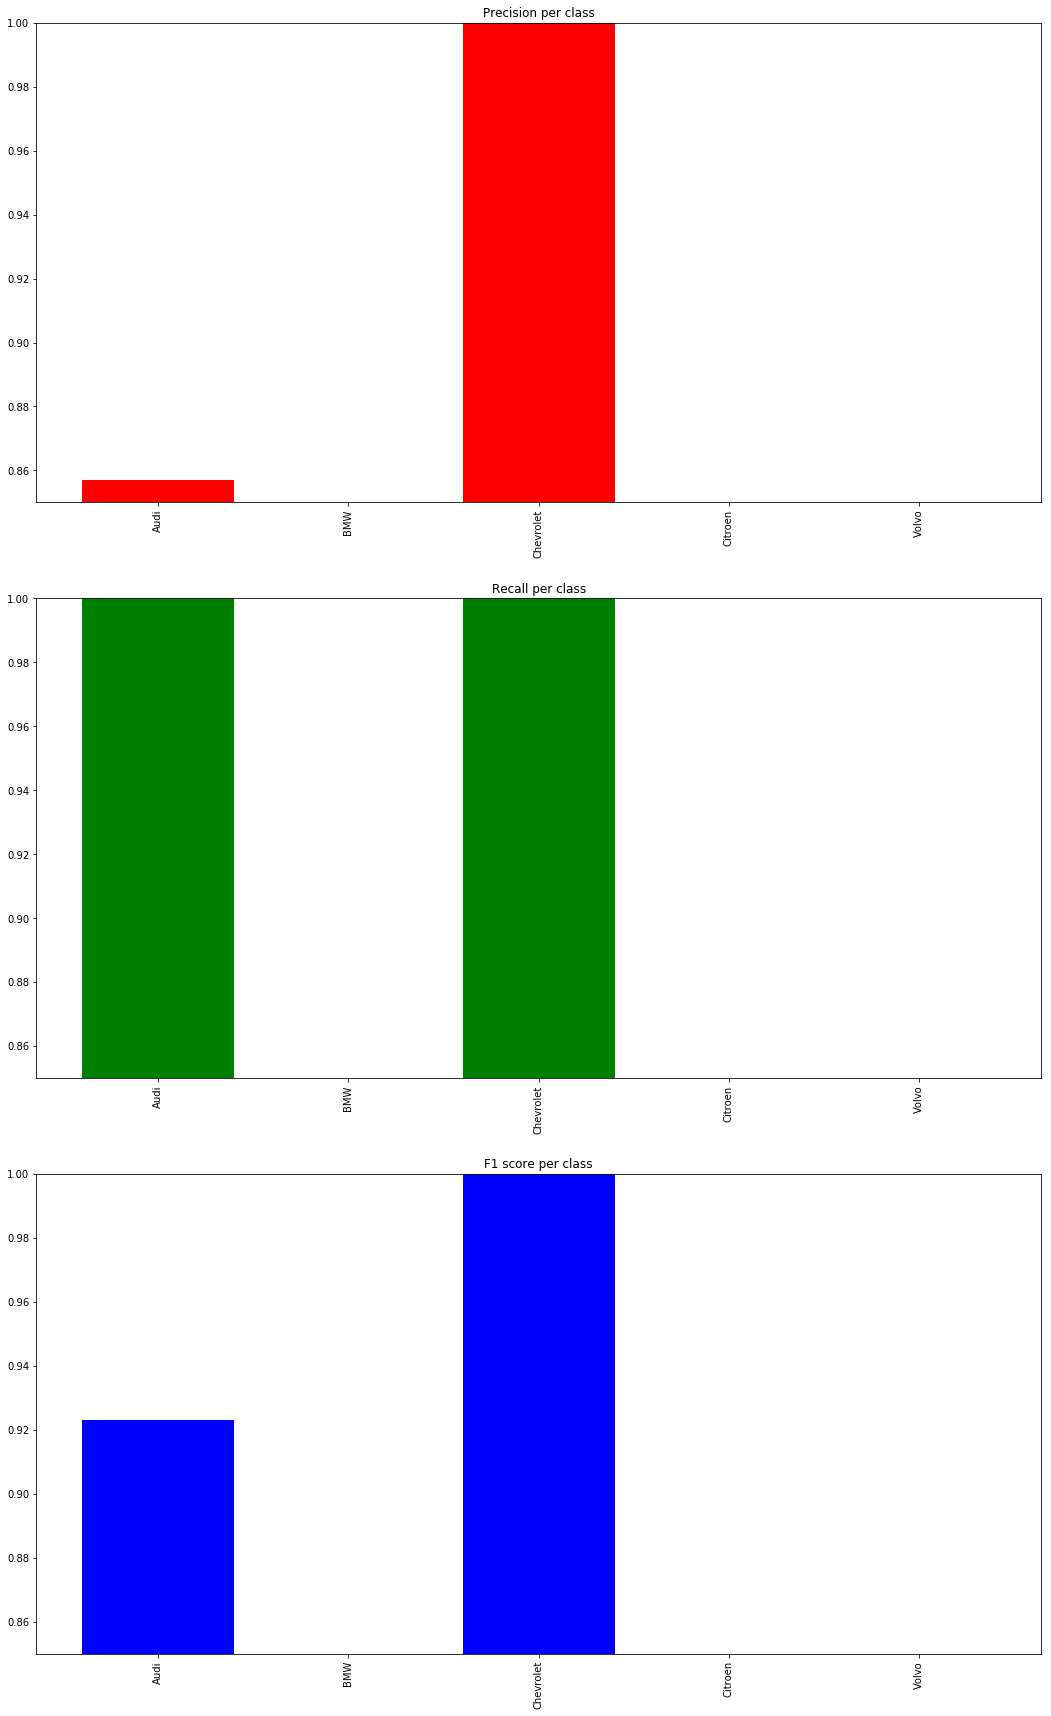

In [22]:
# Graph according to dataset..
plt.subplots(figsize=(18,30))
x = range(len(cars))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.85, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, cars, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.85, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, cars, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.85, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, cars, rotation = 90)
plt.show()

In [23]:

def ImageConvert(n, i):
    im_ex = i.reshape(n, img_x, img_y, 3)
    im_ex = im_ex.astype('float32') / 255
    # zero center data
    im_ex = np.subtract(im_ex, 0.5)
    # ...and to scale it to (-1, 1)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

X_train = ImageConvert(X_train.shape[0], X_train)
X_test = ImageConvert(X_test.shape[0], X_test)

def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(images)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(model.predict_classes(ImageConvert(1, images[r:r+1]), verbose=0))
        
        # increase success if predicted well
        if labels[r] == j:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(images[r].reshape(img_x, img_y, 3))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+cars[labels[r]]+'\nPredicted: '+cars[j],
                  color= 'Green' if cars[labels[r]] == cars[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

Success rate: 47/50 (94.00%)


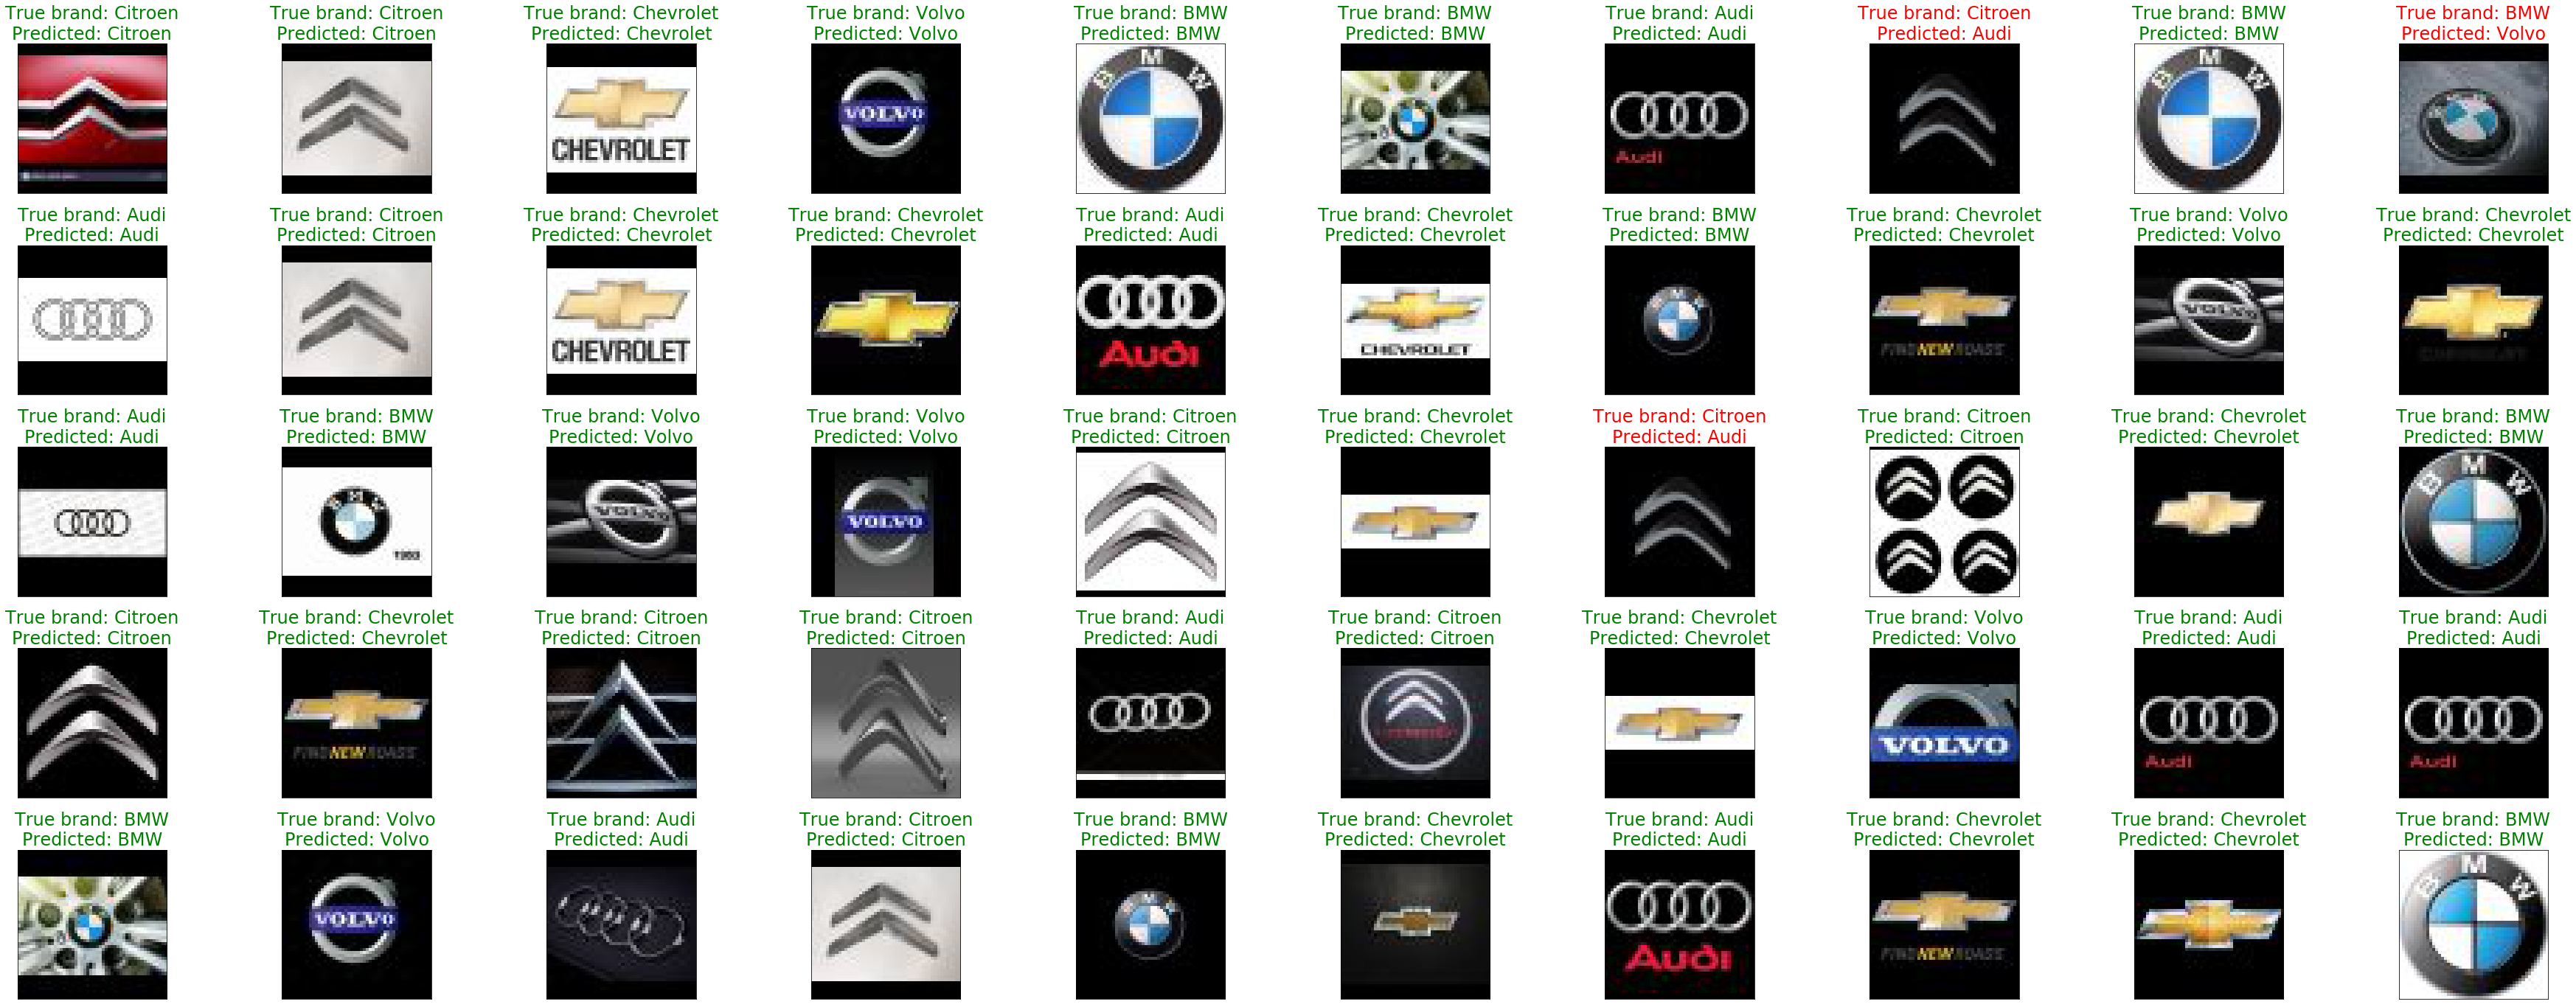

In [24]:
# That is strictly for the showcasing, how the CNN works -
ShowCase(10, 5)


In [25]:
# Setting up the image pool
new_image_path = 'new_img/'
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

8

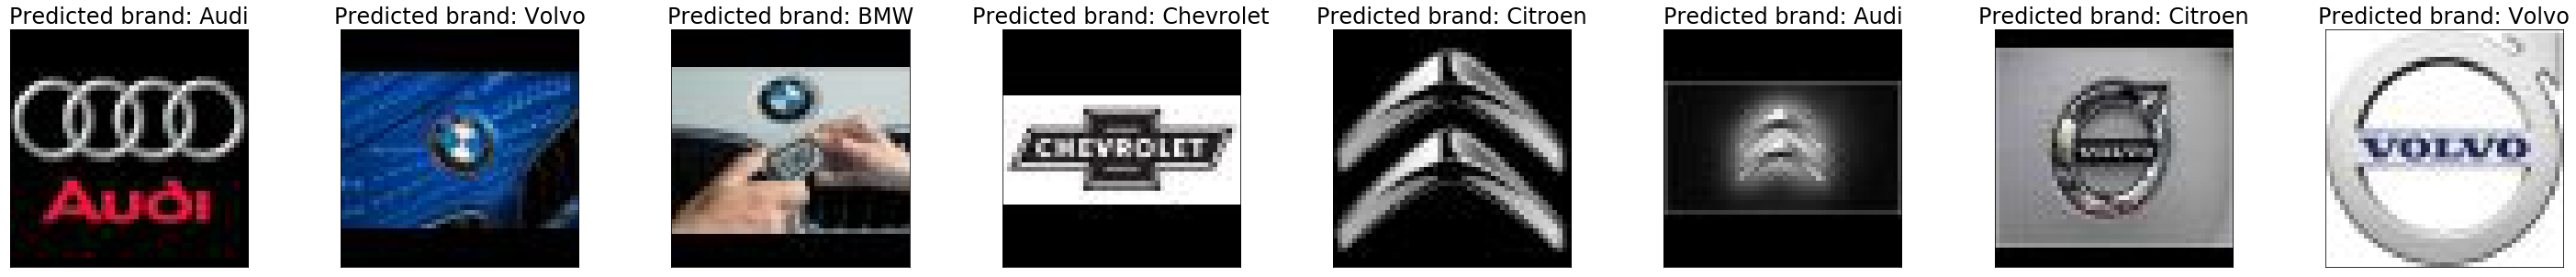

In [26]:
# Let's do some showcasing on-the-fly....
%matplotlib inline
cols = 8
rows = 1
plt.figure(figsize=(cols * 5, rows * 4))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(new_n_samples):
    plt.subplot(rows, cols, i + 1)
    im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
    new_im = np.array(im.resize((50,50))).flatten()
    m = int(model.predict_classes(ImageConvert(1, new_im), verbose=0))
    plt.imshow(new_im.reshape(img_x, img_y, 3))
    plt.title('Predicted brand: '+cars[m], size=24)
    plt.xticks(())
    plt.yticks(())
plt.show()

